In [1]:
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm

In [11]:
df_data = pd.read_csv("./dataset/data_images.csv")

In [6]:
# setup test on fold 1 from 2019-2020 and train on fold 2-5
df_train = df_data[df_data["fold"] == 1].reset_index(drop=True)
df_test = df_data[df_data["fold"] != 1].reset_index(drop=True)

In [17]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms

# the dataframe will be csv file
class ClsLoader(Dataset):
    def __init__(self, csv, mode="train", use_meta=False):
        self.csv = csv
        self.use_meta = use_meta
        self.mode = mode

    def __len__(self):
        # return the number of samples
        return len(self.csv)

    def __getitem__(self, idx):
        # load the image and labels from the csv file
        image = Image.open(self.csv.iloc[idx]["image_path"]).resize((224, 224))
        label = torch.tensor(self.csv.iloc[idx]["target"]).long()

        image = transforms.ToTensor()(image)
        # image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        if self.use_meta:
            #todo add meta data from csv
            pass
            # data = image, torch.tensor(self.csv.iloc[index][self.meta_features]).float())
        else:
            data = image

        if self.mode == "train":
            return data, label
        else:
            return data

In [89]:
# test the loader working
train_loader = ClsLoader(csv=df_train)
image, label = train_loader[10]
# create a batch with 8 image repeat
batch = torch.stack([image for _ in range(8)])


In [154]:
import kornia.augmentation as K
transformation = K.container.AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    K.ColorJitter(brightness=0.2, contrast=0.2, p=0.75),
    K.container.AugmentationSequential(
        K.RandomGaussianBlur((5, 5), (0.1, 2), p=0.5),
        K.RandomGaussianNoise(mean=0.0, std=0.02, p=0.5),
        random_apply=(1, 1),
    ),
    # K.RandomClahe(clip_limit=(2, 2), grid_size=(2, 2), p=0.7),
    K.RandomAffine(degrees=(-15, 15), translate=(0.1, 0.1), scale=(0.9, 0.9), p=0.85),
    K.RandomErasing(scale=(0, 0.3), ratio=(1, 1), value=0.0, p=0.7),
    K.Normalize(
        mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.229, 0.224, 0.225])),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6637104].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.16506..2.550282].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6812202].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2780118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1445982..2.8749478].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Cli

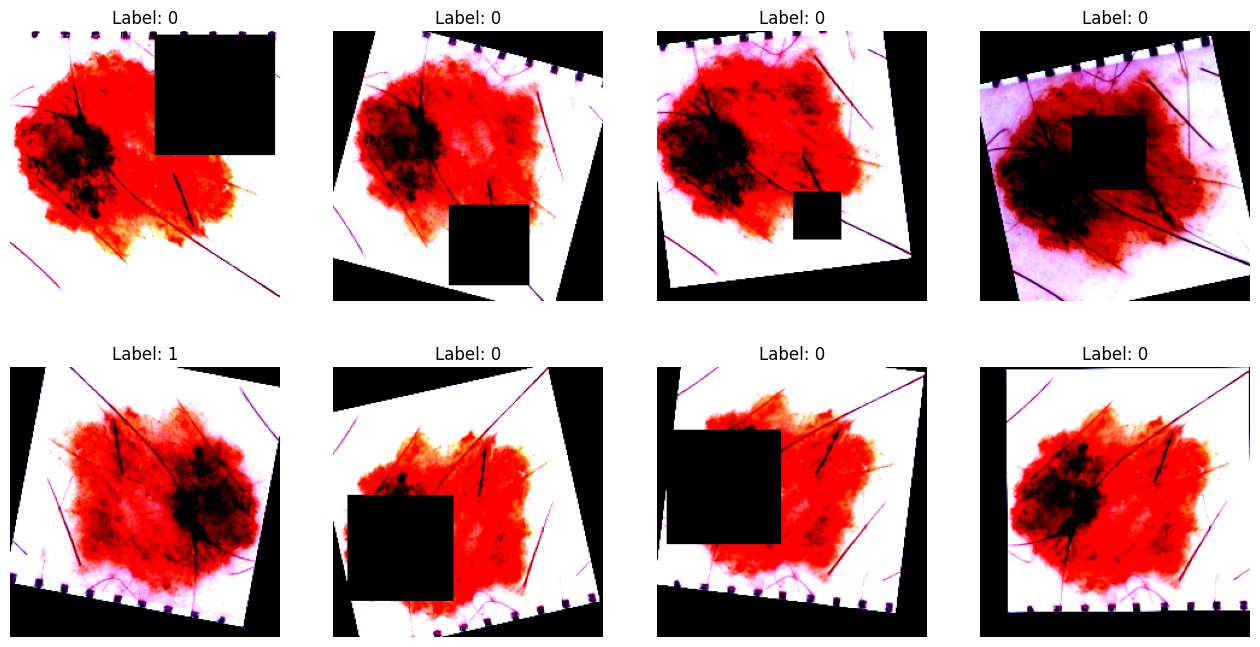

In [161]:
# plot the images, labels

images_aug = transformation(batch)
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16, 8))
# show 8 images
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_aug[i].permute(1, 2, 0))
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")